In [2]:
import pandas as pd

csm = pd.read_csv(
    "csm_daily_returns.csv",
    index_col=0,
    parse_dates=True
).squeeze()

tf = pd.read_csv(
    "portfolio_daily_TF.csv",
    index_col=0,
    parse_dates=True
).squeeze()


In [3]:
csm

Data
2019-02-01    0.0
2019-02-04    0.0
2019-02-05    0.0
2019-02-06    0.0
2019-02-07    0.0
             ... 
2026-01-21    0.0
2026-01-22    0.0
2026-01-23    0.0
2026-01-26    0.0
2026-01-27    0.0
Name: 0, Length: 1756, dtype: float64

In [4]:
tf

Data
2019-02-01    0.000000
2019-02-04    0.000000
2019-02-05    0.000000
2019-02-06    0.000000
2019-02-07    0.000000
                ...   
2026-01-21    0.015721
2026-01-22    0.000478
2026-01-23   -0.003294
2026-01-26    0.000916
2026-01-27   -0.004279
Name: 0, Length: 1756, dtype: float64

In [5]:
print("CSM:", csm.index.min(), "→", csm.index.max())
print("TF :", tf.index.min(),  "→", tf.index.max())


CSM: 2019-02-01 00:00:00 → 2026-01-27 00:00:00
TF : 2019-02-01 00:00:00 → 2026-01-27 00:00:00


In [6]:
assert csm.index.is_unique
assert tf.index.is_unique

assert csm.index.is_monotonic_increasing
assert tf.index.is_monotonic_increasing


In [7]:
combined = pd.concat([csm, tf], axis=1, join="inner")
combined.columns = ["CSM", "TF"]


In [8]:
combined

,CSM,TF
Data,,
2019-02-01,0.0,0.000000
2019-02-04,0.0,0.000000
2019-02-05,0.0,0.000000
2019-02-06,0.0,0.000000
2019-02-07,0.0,0.000000
...,...,...
2026-01-21,0.0,0.015721
2026-01-22,0.0,0.000478
2026-01-23,0.0,-0.003294


In [11]:
combined.isna().sum()


CSM    0
TF     0
dtype: int64

<Axes: title={'center': 'Sanity Check: CSM vs TF Cumulative Returns'}, xlabel='Data'>

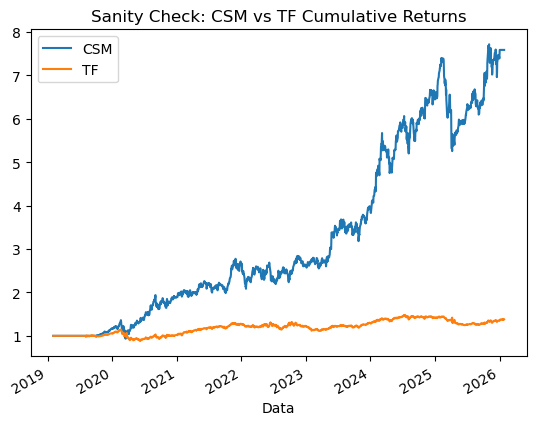

In [12]:
import matplotlib.pyplot as plt

(1 + combined).cumprod().plot(
    title="Sanity Check: CSM vs TF Cumulative Returns"
)


In [13]:
combined.corr()


,CSM,TF
CSM,1.000000,0.264053
TF,0.264053,1.000000


In [14]:
combined.describe()


,CSM,TF
count,1756.000000,1756.000000
mean,0.001323,0.000216
std,0.018355,0.008116
min,-0.144725,-0.082274
25%,-0.006352,-0.003095
50%,0.000000,0.000199
75%,0.010207,0.004285
max,0.125188,0.031048


<Axes: xlabel='Data'>

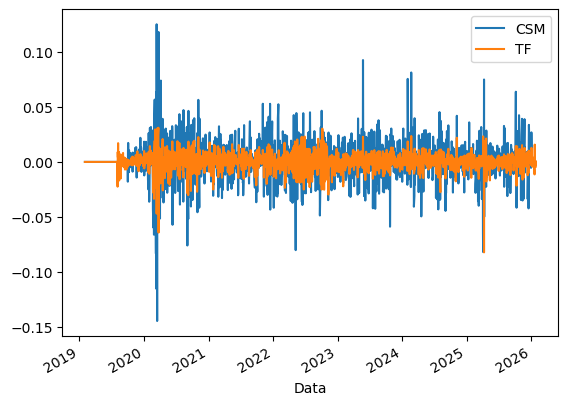

In [20]:
combined.plot()


<Axes: title={'center': 'CSM + TF Daily Returns'}, xlabel='Data'>

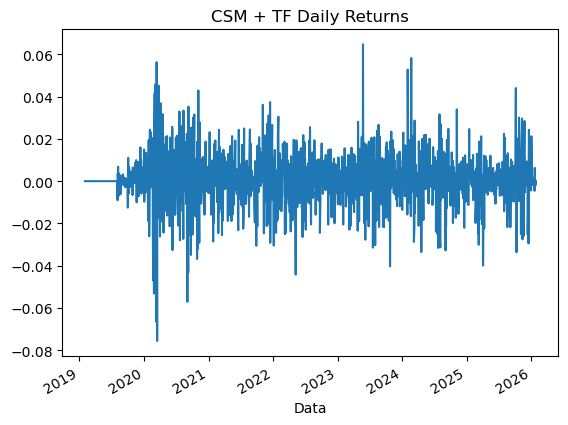

In [17]:
combo = 0.6 * combined["CSM"] + 0.4 * combined["TF"]
combo.plot(title="CSM + TF Daily Returns")


<Axes: title={'center': 'Equity Curves Comparison'}, xlabel='Data'>

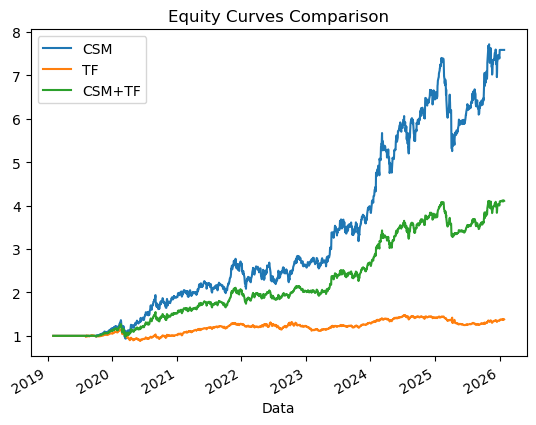

In [18]:
equity = pd.DataFrame({
    "CSM": (1 + combined["CSM"]).cumprod(),
    "TF": (1 + combined["TF"]).cumprod(),
    "CSM+TF": (1 + combo).cumprod()
})

equity.plot(title="Equity Curves Comparison")


In [24]:
import numpy as np
def perf_stats_from_daily_returns(portfolio_daily: pd.Series):
    r = portfolio_daily.dropna()

    equity = (1 + r).cumprod()
    sharpe = np.sqrt(252) * r.mean() / r.std()

    peak = equity.cummax()
    dd = (equity - peak) / peak

    return {
        "Total Return": equity.iloc[-1] - 1,
        "Sharpe": sharpe,
        "Max Drawdown": dd.min(),
        "Annual Vol": np.sqrt(252) * r.std()
    }


In [25]:
print("CSM stats:")
print(perf_stats_from_daily_returns(combined["CSM"]))

print("\nTF stats:")
print(perf_stats_from_daily_returns(combined["TF"]))

print("\nCSM + TF stats:")
print(perf_stats_from_daily_returns(combo))


CSM stats:
{'Total Return': 6.586161875696586, 'Sharpe': 1.1445526224470075, 'Max Drawdown': -0.3117311919821806, 'Annual Vol': 0.29137058237475605}

TF stats:
{'Total Return': 0.3792934564797834, 'Sharpe': 0.42307957145392006, 'Max Drawdown': -0.2306474662398813, 'Annual Vol': 0.1288302370756302}

CSM + TF stats:
{'Total Return': 3.108919196408837, 'Sharpe': 1.1386584595599238, 'Max Drawdown': -0.22520372734406524, 'Annual Vol': 0.1948745501607468}


# Portfolio-level volatility targeting

What problem are we fixing?

Right now, you compared:

-CSM at ~29% annual volatility

-CSM + TF at ~19.5% annual volatility

That is not a fair comparison.

Why?

Because Sharpe assumes:

“Compare strategies at the same risk level.”

So what we must do is:

Scale the combined portfolio up or down so it runs at a chosen target volatility.

That is volatility targeting.

Intuition first (no math)

Think of it like this:

-You built a safer engine (CSM + TF)

-It shakes less

-So you are allowed to press the accelerator more

Volatility targeting answers:

“How much should I scale my position size so my portfolio always runs at ~X% risk?”

What volatility targeting is (very clearly)

Each day, we scale the entire portfolio so its expected volatility equals a fixed target.

Key points:

-We scale the whole portfolio

-We do not change signals

-We do not change weights between CSM and TF

-We only adjust exposure size

This is how real funds operate.

Step 1 — Choose a target volatility

The cleanest choice:

Use CSM’s volatility as the target

From your stats:

CSM annual vol ≈ 29%

So we ask:

“What if the combined portfolio also ran at 29% volatility?”

In [26]:
import numpy as np

def annualized_vol(series):
    return series.std() * np.sqrt(252)

vol_csm = annualized_vol(combined["CSM"])
vol_combo = annualized_vol(combo)

vol_csm, vol_combo


(0.29137058237475605, 0.1948745501607468)

In [27]:
scale = vol_csm / vol_combo
scale


1.4951700062138038

In [29]:
combo_scaled = combo * scale


In [30]:
print("CSM stats:")
print(perf_stats_from_daily_returns(combined["CSM"]))

print("\nVol-targeted CSM + TF stats:")
print(perf_stats_from_daily_returns(combo_scaled))


CSM stats:
{'Total Return': 6.586161875696586, 'Sharpe': 1.1445526224470075, 'Max Drawdown': -0.3117311919821806, 'Annual Vol': 0.29137058237475605}

Vol-targeted CSM + TF stats:
{'Total Return': 6.494169280889675, 'Sharpe': 1.138658459559924, 'Max Drawdown': -0.3251337123809558, 'Annual Vol': 0.29137058237475605}


<Axes: title={'center': 'Volatility-Targeted Comparison'}, xlabel='Data'>

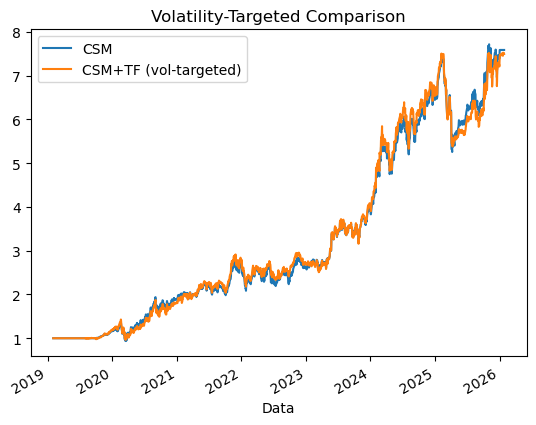

In [31]:
equity = pd.DataFrame({
    "CSM": (1 + combined["CSM"]).cumprod(),
    "CSM+TF (vol-targeted)": (1 + combo_scaled).cumprod()
})

equity.plot(title="Volatility-Targeted Comparison")


# Adding Mean Reversion now

In [33]:
mr = pd.read_csv(
    "portfolio_daily_mr.csv",
    index_col=0,
    parse_dates=True
).squeeze()

In [34]:
mr

Data
2019-02-01    0.000000
2019-02-04    0.000000
2019-02-05    0.000000
2019-02-06    0.000000
2019-02-07    0.000000
                ...   
2026-01-21    0.010156
2026-01-22    0.004879
2026-01-23   -0.007393
2026-01-26    0.007318
2026-01-27    0.007693
Name: 0, Length: 1756, dtype: float64

{'Total Return': 0.946150505887003, 'Sharpe': 0.5500311759661449, 'Max Drawdown': -0.30809140921854056, 'Annual Vol': 0.21603383211386992}


<Axes: title={'center': 'MR Equity Curve'}, xlabel='Data'>

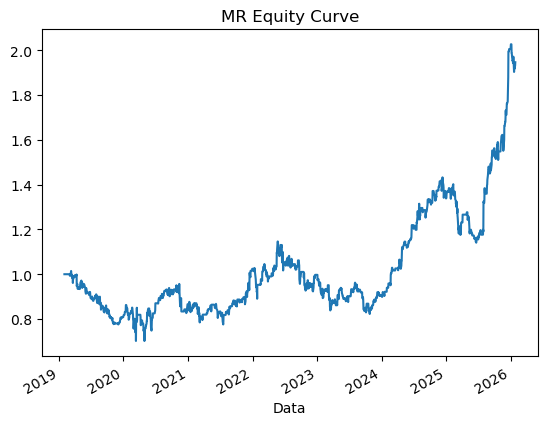

In [36]:
print(perf_stats_from_daily_returns(mr))
(1 + mr).cumprod().plot(title="MR Equity Curve")

In [39]:
combined3 = pd.concat(
    [csm,tf,mr],
    axis=1,
    keys=["CSM", "TF", "MR"]
).dropna()

combined3.corr()

<bound method DataFrame.corr of             CSM        TF        MR
Data                               
2019-02-01  0.0  0.000000  0.000000
2019-02-04  0.0  0.000000  0.000000
2019-02-05  0.0  0.000000  0.000000
2019-02-06  0.0  0.000000  0.000000
2019-02-07  0.0  0.000000  0.000000
...         ...       ...       ...
2026-01-21  0.0  0.015721  0.010156
2026-01-22  0.0  0.000478  0.004879
2026-01-23  0.0 -0.003294 -0.007393
2026-01-26  0.0  0.000916  0.007318
2026-01-27  0.0 -0.004279  0.007693

[1756 rows x 3 columns]>

In [40]:
combined3.corr()

,CSM,TF,MR
CSM,1.000000,0.264053,0.379478
TF,0.264053,1.000000,0.211385
MR,0.379478,0.211385,1.000000


In [42]:
combo3 = (
    0.5 * combined3["CSM"] +
    0.3 * combined3["TF"] +
    0.2 * combined3["MR"]
)


<Axes: title={'center': 'Equity Curves Comparison'}, xlabel='Data'>

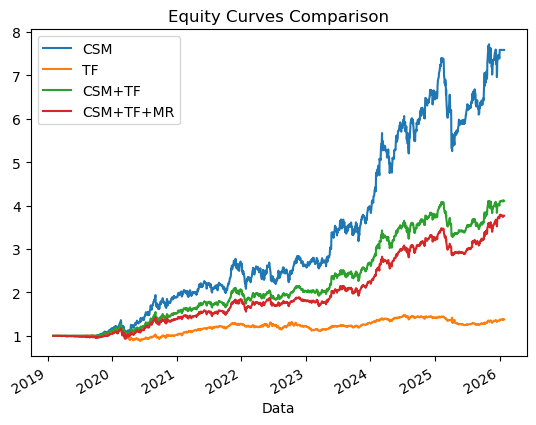

In [43]:
equity = pd.DataFrame({
    "CSM": (1 + combined["CSM"]).cumprod(),
    "TF": (1 + combined["TF"]).cumprod(),
    "CSM+TF": (1 + combo).cumprod(),
    "CSM+TF+MR": (1 + combo3).cumprod()
})

equity.plot(title="Equity Curves Comparison")


In [44]:
print("CSM stats:")
print(perf_stats_from_daily_returns(combined["CSM"]))

print("\nTF stats:")
print(perf_stats_from_daily_returns(combined["TF"]))

print("\nCSM + TF stats:")
print(perf_stats_from_daily_returns(combo))

print("\nCSM + TF + MR stats:")
print(perf_stats_from_daily_returns(combo3))

CSM stats:
{'Total Return': 6.586161875696586, 'Sharpe': 1.1445526224470075, 'Max Drawdown': -0.3117311919821806, 'Annual Vol': 0.29137058237475605}

TF stats:
{'Total Return': 0.3792934564797834, 'Sharpe': 0.42307957145392006, 'Max Drawdown': -0.2306474662398813, 'Annual Vol': 0.1288302370756302}

CSM + TF stats:
{'Total Return': 3.108919196408837, 'Sharpe': 1.1386584595599238, 'Max Drawdown': -0.22520372734406524, 'Annual Vol': 0.1948745501607468}

CSM + TF + MR stats:
{'Total Return': 2.7651185853426794, 'Sharpe': 1.1380156890443662, 'Max Drawdown': -0.20391478109290295, 'Annual Vol': 0.18177357752165146}


# Again Volatility target portfolio

In [45]:
vol_combo3 = annualized_vol(combo3)
vol_combo3

0.18177357752165146

In [46]:
scale3 = vol_csm / vol_combo3
scale3

1.6029314400221355

In [48]:
combo3_vol_targeted = combo3 * scale3


In [51]:
print("CSM stats:")
print(perf_stats_from_daily_returns(combined["CSM"]))

print("\nTF stats:")
print(perf_stats_from_daily_returns(combined["TF"]))

print("\nCSM + TF stats:")
print(perf_stats_from_daily_returns(combo))

print("\nCSM + TF + MR stats:")
print(perf_stats_from_daily_returns(combo3))

print("\nCSM + TF + MR volatility targeted stats:")
print(perf_stats_from_daily_returns(combo3_vol_targeted))

CSM stats:
{'Total Return': 6.586161875696586, 'Sharpe': 1.1445526224470075, 'Max Drawdown': -0.3117311919821806, 'Annual Vol': 0.29137058237475605}

TF stats:
{'Total Return': 0.3792934564797834, 'Sharpe': 0.42307957145392006, 'Max Drawdown': -0.2306474662398813, 'Annual Vol': 0.1288302370756302}

CSM + TF stats:
{'Total Return': 3.108919196408837, 'Sharpe': 1.1386584595599238, 'Max Drawdown': -0.22520372734406524, 'Annual Vol': 0.1948745501607468}

CSM + TF + MR stats:
{'Total Return': 2.7651185853426794, 'Sharpe': 1.1380156890443662, 'Max Drawdown': -0.20391478109290295, 'Annual Vol': 0.18177357752165146}

CSM + TF + MR volatility targeted stats:
{'Total Return': 6.486714244764445, 'Sharpe': 1.138015689044367, 'Max Drawdown': -0.3143219123912753, 'Annual Vol': 0.2913705823747559}


<Axes: title={'center': 'CSM vs Vol-Targeted 3-Alpha Portfolio'}, xlabel='Data'>

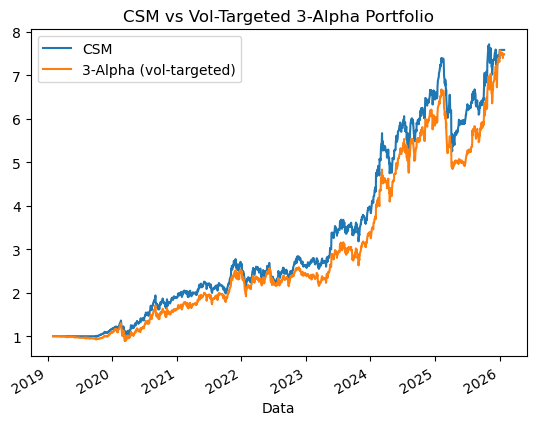

In [50]:
equity = pd.DataFrame({
    "CSM": (1 + combined["CSM"]).cumprod(),
    "3-Alpha (vol-targeted)": (1 + combo3_vol_targeted).cumprod()
})

equity.plot(title="CSM vs Vol-Targeted 3-Alpha Portfolio")
